# Data loading

In [92]:
import torchvision
from torchvision import datasets
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim

from __future__ import print_function
import time
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

%matplotlib inline

batch_size = 12

train_data = datasets.MNIST('D:\datasets',train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST('D:\datasets',train=False, download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)

# Model

In [93]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.in_dim = 28*28 #MNIST
        self.out_dim = 10
        
        self.fc1 = nn.Linear(self.in_dim, 512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,128)
        self.fc4 = nn.Linear(128,64)
        self.fc5 = nn.Linear(64,self.out_dim)
        
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax()
        
    def forward(self,x):
        z1 = self.fc1(x.view(-1, self.in_dim))
        a1 = self.relu(z1)
        z2 = self.fc2(a1)
        a2 = self.relu(z2)
        a3 = self.relu(self.fc3(a2))
        a4 = self.relu(self.fc4(a3))
        logit = self.fc5(a4)
        return logit,(z1,a1,z2,a2)

# Train

In [94]:
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

In [95]:
z1 = torch.Tensor([])
a1 = torch.Tensor([])
z2 = torch.Tensor([])
a2 = torch.Tensor([])
y = torch.Tensor([])

In [96]:
for epoch in range(10): #loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        #get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        #zero the parameter gradients
        optimizer.zero_grad()
        
        #forward + backward + optimize
        outputs, toch = model(inputs)
        
        if (epoch == 9):
            z1 = torch.cat((toch[0],z1),0)
            a1 = torch.cat((toch[1],a1),0)
            z2 = torch.cat((toch[2],z2),0)
            a2 = torch.cat((toch[3],a2),0)
            y = torch.cat((labels,y),0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #print statistics
        running_loss += loss.item()
        if (i+1)%2000==0:    #print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                 (epoch+1, i+1, running_loss/2000))
            running_loss =0.0
            
print('Finished Training')

[1,  2000] loss: 2.120
[1,  4000] loss: 0.655
[2,  2000] loss: 0.309
[2,  4000] loss: 0.236
[3,  2000] loss: 0.161
[3,  4000] loss: 0.137
[4,  2000] loss: 0.103
[4,  4000] loss: 0.100
[5,  2000] loss: 0.080
[5,  4000] loss: 0.081
[6,  2000] loss: 0.058
[6,  4000] loss: 0.062
[7,  2000] loss: 0.047
[7,  4000] loss: 0.051
[8,  2000] loss: 0.036
[8,  4000] loss: 0.039
[9,  2000] loss: 0.028
[9,  4000] loss: 0.028
[10,  2000] loss: 0.022
[10,  4000] loss: 0.024
Finished Training


In [97]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

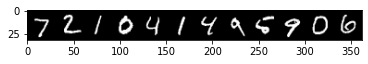

GroundTruth
   7   2   1   0   4   1   4   9   5   9   0   6
Prediction
   7   2   1   0   4   1   4   9   5   9   0   6


In [98]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images, nrow=batch_size))
print('GroundTruth')
print(" "+' '.join('%3s'%label.item() for label in labels))

outputs ,_ = model(images)
_, predicted = torch.max(outputs, 1)
print("Prediction")
print(" "+' '.join('%3s' % label.item() for label in predicted))

In [99]:
n_predict = 0
n_correct = 0

for data in test_loader:
    inputs, labels = data
    outputs ,_ = model(inputs)
    _, predicted = torch.max(outputs, 1)
    
    n_predict += len(predicted)
    n_correct += (labels == predicted).sum()
    
print(f"{n_correct}/{n_predict}")
print(f"Accuracy: {n_correct/n_predict:.3f}")

9752/10000
Accuracy: 0.975


In [100]:
def visualization(x,y):
    x = (x.data.view(-1,x.data.shape[1]) / 255.0).numpy()
    y = y.numpy()
    print(f'x.shape : {x.shape}')
    print(f'y.shape : {y.shape}')
    
    feat_cols = [f'pixel{i}' for i in range(x.shape[1])]
    df = pd.DataFrame(x, columns = feat_cols)
    df['y'] = y
    
    np.random.seed(42)
    rndperm = np.random.permutation(df.shape[0])
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df[feat_cols].values)
    df['pca-one'] = pca_result[:,0]
    df['pca-two'] = pca_result[:,1]
    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
    
    plt.figure(figsize=(13,9))
    sns.scatterplot(
        x="pca-one", y="pca-two",hue="y",
        palette=sns.color_palette("hls",10),
        data=df.loc[rndperm,:],
        legend="full", alpha=0.3)

    N=10000
    df_subset = df.loc[rndperm[:N],:].copy()
    data_subset = df_subset[feat_cols].values
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data_subset)
    df_subset['pca-one']=pca_result[:,0]
    df_subset['pca-two']=pca_result[:,1]
    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(data_subset)
    df_subset['tsne-2d-one']=tsne_results[:,0]
    df_subset['tsne-2d-two']=tsne_results[:,1]
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

    plt.figure(figsize=(13,9))
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",hue="y",
        palette=sns.color_palette("hls",10),
        data=df_subset,
        legend="full", alpha=0.3)
    plt.show()

x.shape : (60000, 784)
y.shape : (60000,)
Explained variation per principal component: [0.09704709 0.07095959]
Explained variation per principal component: [0.09614986 0.07138533]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.005s...


/Users/imsoyun/opt/anaconda3/envs/ai21/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/imsoyun/opt/anaconda3/envs/ai21/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 10000 samples in 3.615s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.136576
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.890274
[t-SNE] KL divergence after 300 iterations: 2.818424
t-SNE done! Time elapsed: 20.186479806900024 seconds


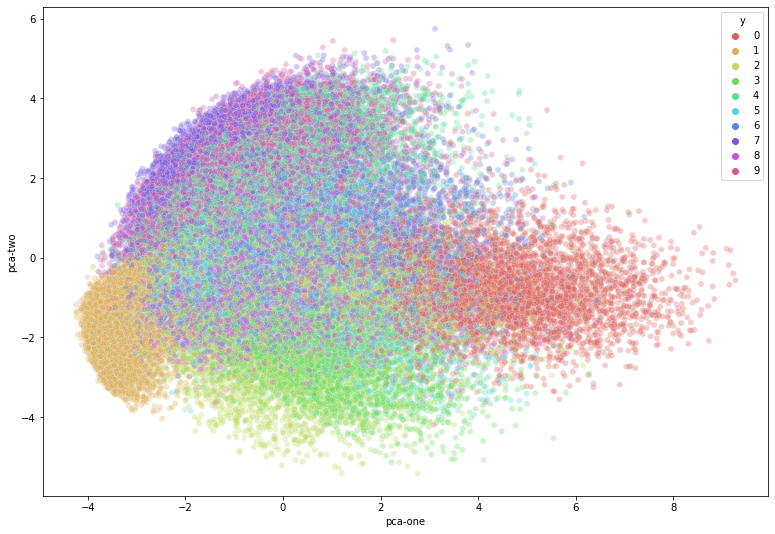

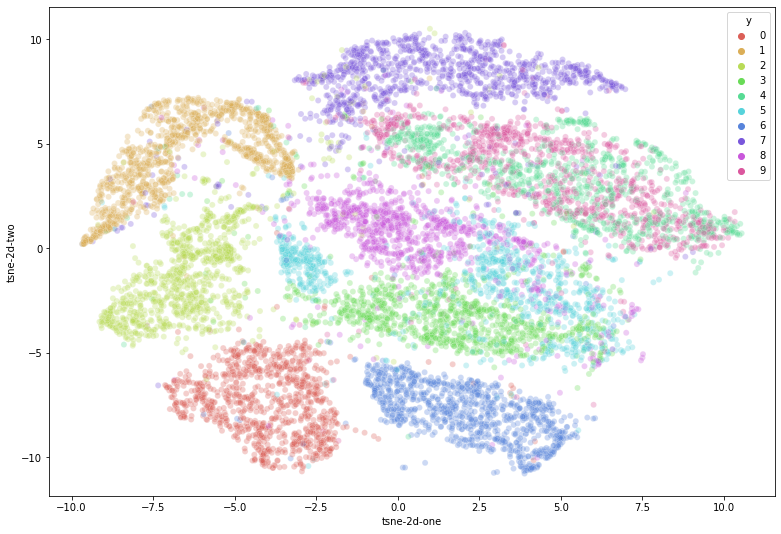

In [101]:
this=train_data.data 
this=this.reshape(60000,784)
visualization(this,train_data.targets)

x.shape : (60000, 512)
y.shape : (60000,)
Explained variation per principal component: [0.16030794 0.12563461]
Explained variation per principal component: [0.16318099 0.12660998]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.004s...


/Users/imsoyun/opt/anaconda3/envs/ai21/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/imsoyun/opt/anaconda3/envs/ai21/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 10000 samples in 3.473s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.008576
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.621117
[t-SNE] KL divergence after 300 iterations: 2.695335
t-SNE done! Time elapsed: 18.023072004318237 seconds


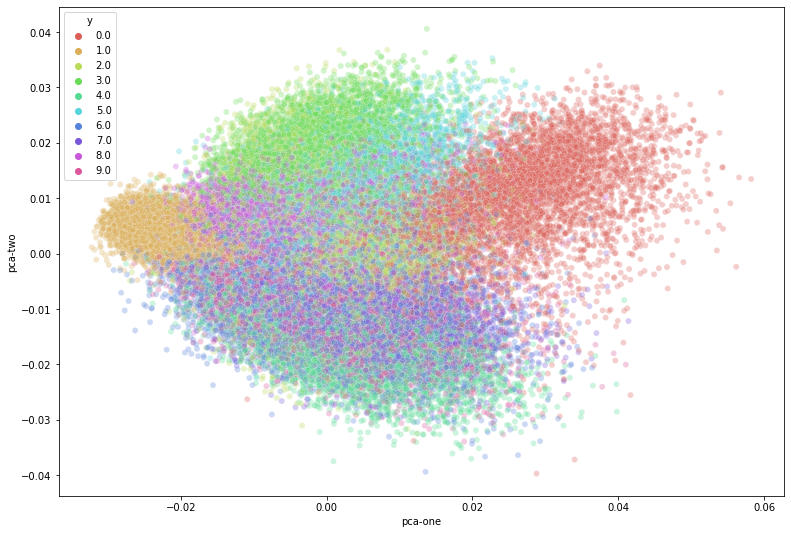

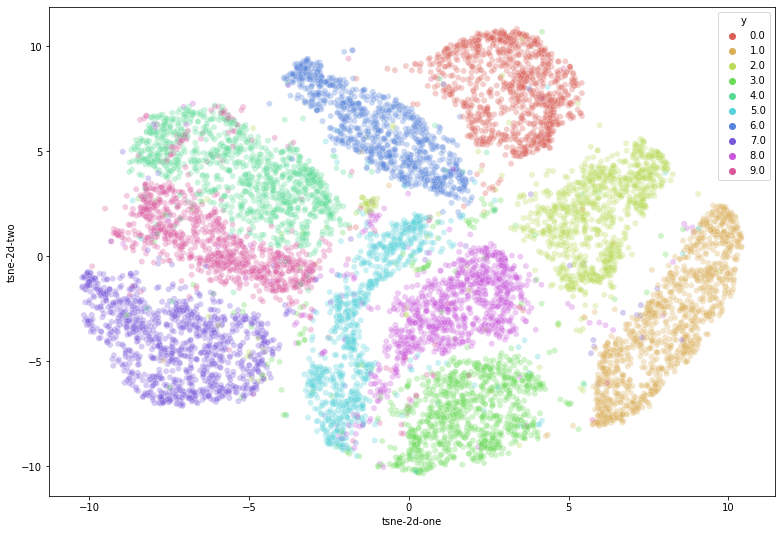

In [102]:
visualization(z1,y)

x.shape : (60000, 512)
y.shape : (60000,)
Explained variation per principal component: [0.12288939 0.10189807]
Explained variation per principal component: [0.12779613 0.10053189]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.004s...


/Users/imsoyun/opt/anaconda3/envs/ai21/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/imsoyun/opt/anaconda3/envs/ai21/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 10000 samples in 3.141s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.004416
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.610069
[t-SNE] KL divergence after 300 iterations: 2.649997
t-SNE done! Time elapsed: 17.100303888320923 seconds


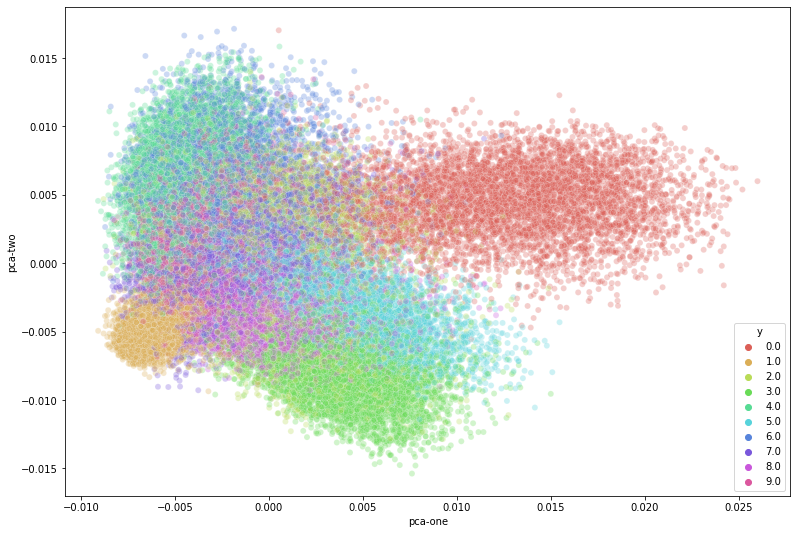

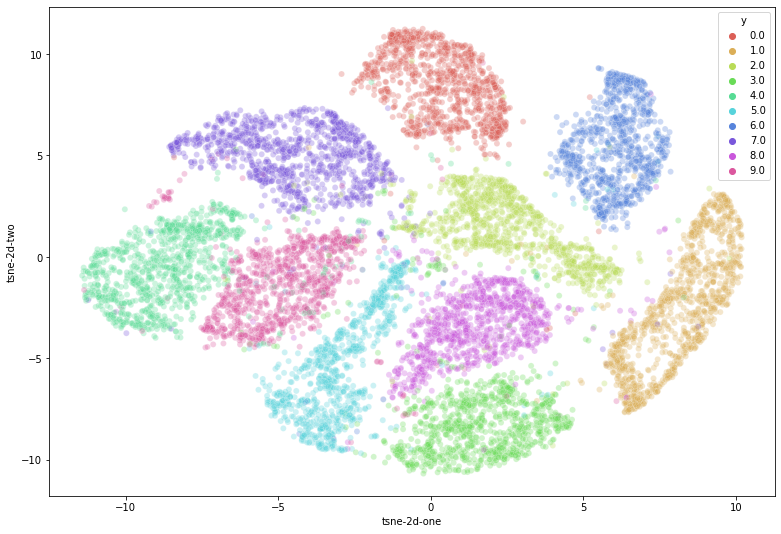

In [103]:
visualization(a1,y)

x.shape : (60000, 256)
y.shape : (60000,)
Explained variation per principal component: [0.2325238  0.19199608]
Explained variation per principal component: [0.22937936 0.19733614]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.002s...


/Users/imsoyun/opt/anaconda3/envs/ai21/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/imsoyun/opt/anaconda3/envs/ai21/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 10000 samples in 2.702s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.002825
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.587120
[t-SNE] KL divergence after 300 iterations: 2.532216
t-SNE done! Time elapsed: 16.980431079864502 seconds


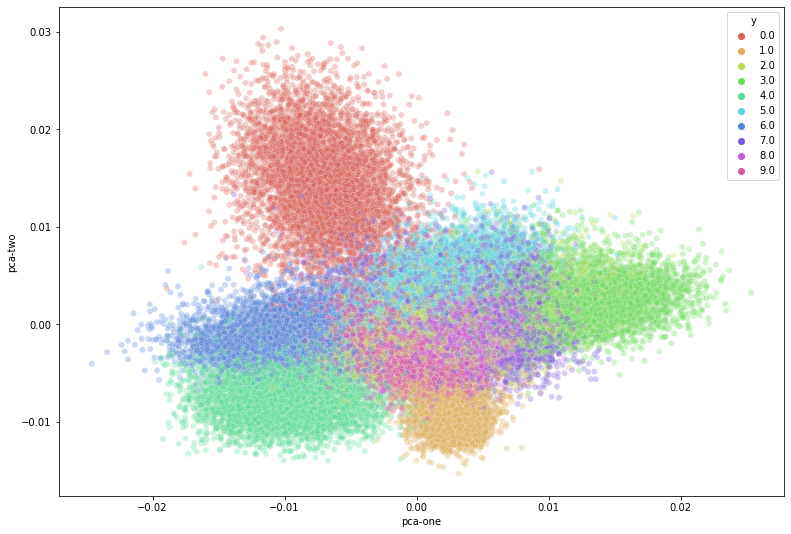

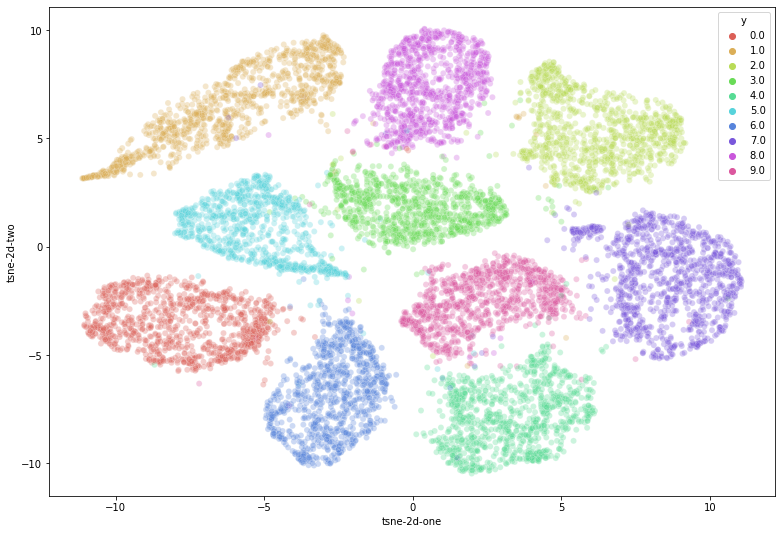

In [104]:
visualization(z2,y)

x.shape : (60000, 256)
y.shape : (60000,)
Explained variation per principal component: [0.21957113 0.19424976]
Explained variation per principal component: [0.21696992 0.19708148]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.002s...


/Users/imsoyun/opt/anaconda3/envs/ai21/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/imsoyun/opt/anaconda3/envs/ai21/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 10000 samples in 2.695s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.002376
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.268692
[t-SNE] KL divergence after 300 iterations: 2.527424
t-SNE done! Time elapsed: 17.30673098564148 seconds


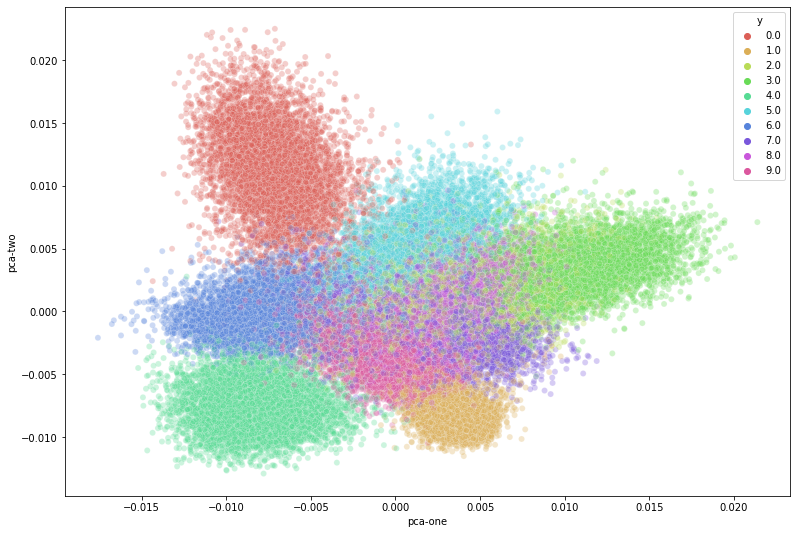

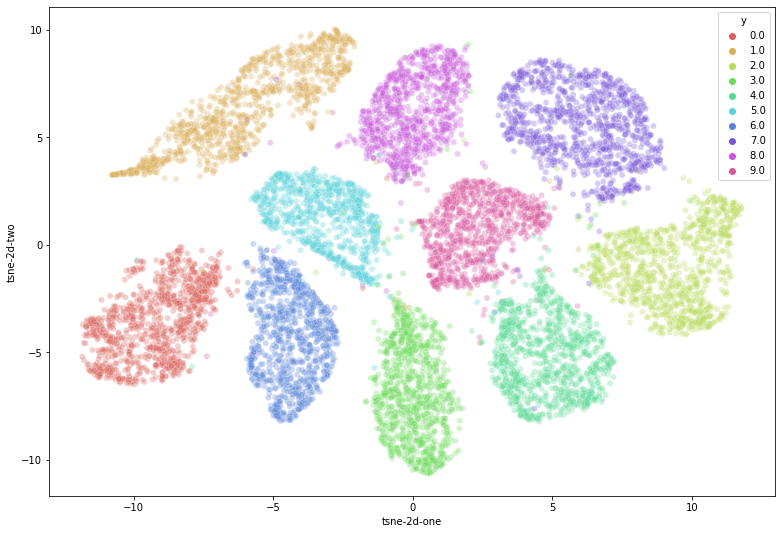

In [105]:
visualization(a2,y)